# Processing of the Dataset 

-  In this notebook, I will write the code for importing, processing and generating the features from the raw audio files downloaded from the public dataset [UrbanSound8K](https://serv.cusp.nyu.edu/projects/urbansounddataset/urbansound8k.html).  


## Dependencies

-  The python packages mentioned below.
-  Two additional packages (also mentioned below) that I created which are available in the repository. 
-  The audio files from the dataset. In the repository, a test folder is uploaded containing 59 audio files from the dataset.

In [34]:
# Lets import some packages
import santiago_my_modules_v3_16_04_18 as my
import santiago_data_preprocessing as prep
import math
import numpy as np
import h5py
import imp
import matplotlib.pyplot as plt
import time
import pandas as pd
import wave
import os
import struct
import IPython.display as ipd
import random
import librosa
import soundfile as sf
from scipy.io import wavfile
from scipy import signal

## Below, the main function for reading and processing the audio files <br>

In [35]:
def get_files_and_resample(sampling_rate_new, desired_length_seconds, noise = False, noise_all = False, db_SNR = 0):
    
# A function to import the original files, resample them and get also their Class Id
    # Inputs:
        # sampling_rate_new - the new sampling rate we want to apply to all audio files
        # desired_length_seconds - length we want the audio files to have
        # noise - Boolean. Whether to apply noise or not
        # noise_all - Boolean. If noise = True, whether to apply the noise to the whole file (extended) or only to original duration
        # db_SNR - If noise = True, specify Signal to Noise Ratio (in dB)
    # Outputs:
        # x, matrix with dimensions (sampling_rate_new*duration, number_of_examples)
        # y, vector with dimensions (1,number_of_examples)
    
    startpath = os.path.abspath("UrbanSound8K_Test\\audio")
    list_with_file_names1 = os.listdir(startpath) 


    duration_samples = int(desired_length_seconds * sampling_rate_new)
    y_list = []
    x_list =[]
    index = 0
    
    for file1 in list_with_file_names1:  #Loop over the different folders (fold1, fold2,...)

        if file1 == '.DS_Store':         #Ommit this file
            continue

        completePath1 = os.path.join(startpath,file1) 

        list_with_file_names2 = os.listdir(completePath1)
        

        for file2 in list_with_file_names2: #Loop over the different audio files in the different folders

            if file2 == '.DS_Store':        #Ommit this file
                continue
                
            completePath2 = os.path.join(completePath1,file2)
            
            index += 1                      #To keep track of the files for debugging
            
            class_id = file2.split("-")[1]  #Extract the class id, e.g. 9031-3-1-0.wav --> Class id = 3


            input_file, sampling_rate_orig = sf.read(completePath2) #Read input file (sf supports 24-bit inputs)
            
            if input_file.ndim == 2:
                input_file = input_file[:,0] #Monochannel
                       
            inputfile_resampled = librosa.resample(input_file, sampling_rate_orig, sampling_rate_new) #Resampling
            
            if len(inputfile_resampled) < duration_samples:
                x_files = prep.zero_pad(inputfile_resampled, sampling_rate_new, desired_length_seconds, 
                                  noise = noise, noise_all = noise_all, db_SNR = db_SNR, index=index)
               #x_files = prep.extend_file(inputfile_resampled, sampling_rate_new, desired_length_seconds)


            elif noise == True:
                x_files = prep.add_noise(inputfile_resampled[0:duration_samples], db_SNR, index = index)
            
            else:
                x_files = inputfile_resampled[0:duration_samples]
                
                
            y_list.append(class_id)
            x_list.append(x_files)
            
    
    x = np.transpose(np.array(x_list)) #creates an array from the list of arrays, and transposes it to get the desired shape
    y = np.array(y_list).astype(int) #convert the list to an array on integers

    
    return x, y 


# Processing the audio files

In [37]:
# SELECT PARAMETERS
sampling_rate_new = 22050   # sampling rate to resample audio files to (in Hz)
duration = 3                # duration that I want the audio files to have (in seconds)
mel_bands = 60              # mel frequency bands to extract
window_size = 1024          # for the STFT window (in samples)
hop_length = 512            # for the STFT (in samples)
db_SNR = 0                  # SNR pink noise (in dB)

# STARTS TIMER
t = time.time()

# PROCESS AUDIO FILES
x, y = get_files_and_resample(sampling_rate_new, duration, noise = False, noise_all = False, db_SNR = db_SNR)

# FEATURE GENERATION, SPECTROGRAM CALCULATION
features1 = prep.get_mel_spectrogram(x, sampling_rate_new, mel_bands, window_size, hop_length)
features2 = prep.get_spectrogram(x, window_size, hop_length) 

# TIME ELAPSED
elapsed = time.time() - t

# PRINT SOME INFORMATION
print ('Time elapsed: %.2f seconds' %elapsed)
print('Shape of x: %s ' %(x.shape,))
print('Shape of y: %s ' %(y.shape,))
print('Shape of features: %s ' %(features2.shape,))

# SAVE FILES
#np.save(r'C:\Users\Santiago\deep-machine-learning\UrbanSound8K_Treated\sr22050,duration3_leveldiff\orig_features_dB.npy' , features)


Time elapsed: 8.26 seconds
Shape of x: (66150, 59) 
Shape of y: (59,) 
Shape of features: (513, 130, 59) 


# Let's hear and visualize an example

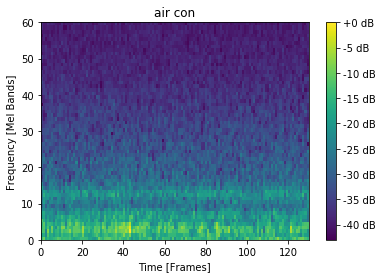

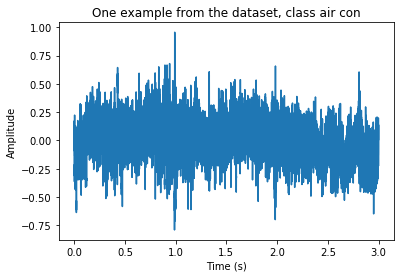

In [33]:
#Idx of example to plot
example = 7  


############################################
#### Generate the mel-spectrogram plot #####
############################################

#Time vector
t = np.arange(130) 

#Frequency vector
f = np.arange(60)

Sxx = features1[:,:,example]

class_names = ['air con','car horn','children pl.','dog bark','drilling','engine','gun shot','jackhammer','siren','street music']

fig, ax = plt.subplots(1)

p = ax.pcolormesh(Sxx)

fig.colorbar(p, format='%+2.0f dB')

plt.pcolormesh(t, f, Sxx)
plt.title(class_names[y[example]])
plt.ylabel('Frequency [Mel Bands]')
plt.xlabel('Time [Frames]')
plt.show()



############################################
#### Generate the signal amplitude plot ####
############################################


time_vector = np.arange(0,x.shape[0],1) / sampling_rate_new

# Create the plot
plt.plot(time_vector, x[:,example])

#Label the axes
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")

#Set the title
plt.title("One example from the dataset, class %s" %class_names[y[example]])

#Display the plot
plt.show()


#Write the audio file to then play it. Change the folder!
sf.write(r'C:\Users\Santiago\deep-machine-learning\Sounds_for_notebooks\Ejemplin.wav', x[:,example], sampling_rate_new)
ipd.display(ipd.Audio(filename = r'C:\Users\Santiago\deep-machine-learning\Sounds_for_notebooks\Ejemplin.wav'))

